Gerekli python kütüphanelerinin yüklenmesi


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

Google Drive Bağlantısı

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/MyDrive/dataset'

Veri Ön İşleme
Veri Yükleme ve Ayırma (Rescaling ve Splitting)
 128x128 piksel boyutu edildi. Aynı zamanda piksel değerlerini 0-1 arasına normalize edildi. (rescale=1./255).

In [4]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print("\nSınıf İsimleri:", class_names)
NUM_CLASSES = len(class_names)
print("Sınıf Sayısı:", NUM_CLASSES)

Found 107 files belonging to 2 classes.
Using 86 files for training.
Found 107 files belonging to 2 classes.
Using 21 files for validation.

Sınıf İsimleri: ['Hiq Protein Tozu', 'Protein Ocean Creatin']
Sınıf Sayısı: 2


Normalizasyon Katmanı ekleme


In [5]:

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Basit CNN Mimarisi

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Basit CNN Modeli Mimarisi (Model 2)
model_2 = Sequential([
    # 1. Konvolüsyon Katmanı
    Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SIZE + (3,)),
    MaxPooling2D((2, 2)),

    # 2. Konvolüsyon Katmanı
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # 3. Konvolüsyon Katmanı (Opsiyonel: Daha Derin Bir Model İçin)
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Düzleştirme (Flatten)
    Flatten(),

    # Yoğun Katmanlar (Dense Layers)
    Dense(128, activation='relu'),
    Dropout(0.5), # Aşırı öğrenmeyi engellemek için dropout ekle
    Dense(NUM_CLASSES, activation='softmax') # Çıkış katmanı (2 sınıf)
])

print("--- Model 2 Özeti (Basit CNN) ---")
model_2.summary()

--- Model 2 Özeti (Basit CNN) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Modeli Derle (Compile)
model_2.compile(
    optimizer='adam', # Adam optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Model Eğitimi (Train)
EPOCHS = 30

history_2 = model_2.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

print("\nModel 2 Eğitimi Tamamlandı!")

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step - accuracy: 0.5350 - loss: 0.7203 - val_accuracy: 0.3333 - val_loss: 0.8114
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5836 - loss: 0.6869 - val_accuracy: 0.3810 - val_loss: 0.7050
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6440 - loss: 0.6367 - val_accuracy: 0.3810 - val_loss: 0.7307
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6555 - loss: 0.6096 - val_accuracy: 0.4762 - val_loss: 0.7166
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7548 - loss: 0.5595 - val_accuracy: 0.8095 - val_loss: 0.4981
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8640 - loss: 0.4274 - val_accuracy: 0.9048 - val_loss: 0.3414
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8249 - loss: 0.3862 - val_accuracy: 0.8095 - val_loss: 0.3845
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8521 - loss: 0.3352 - val_accuracy: 0.7619 - val_loss: 0.4250
Epoch 9/30
3/3 

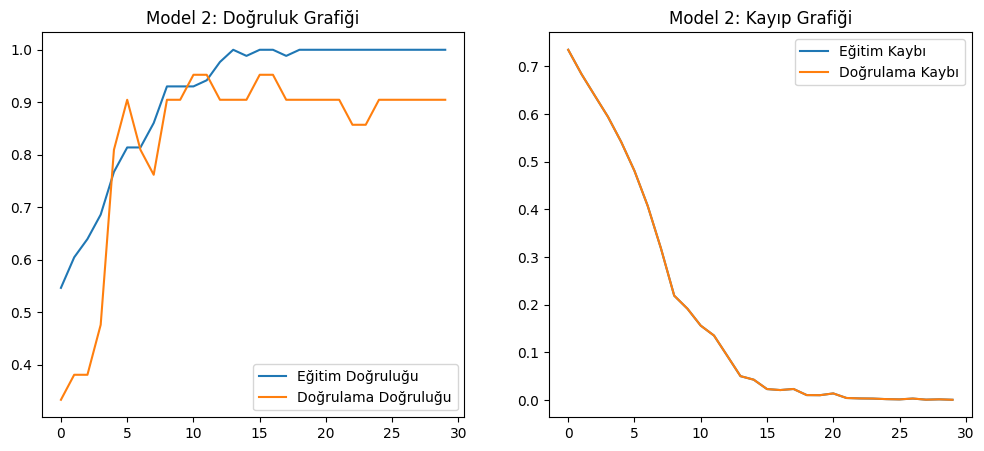

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step - accuracy: 0.9048 - loss: 0.4055

Model 2 (Basit CNN) Test Seti Doğruluğu: 90.48%
Model 2 Test Seti Kaybı: 0.4055


In [8]:
import matplotlib.pyplot as plt

# Grafik Çizimi
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Eğitim Doğruluğu')
plt.plot(val_acc, label='Doğrulama Doğruluğu')
plt.title('Model 2: Doğruluk Grafiği')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Eğitim Kaybı')
plt.plot(val_loss, label='Doğrulama Kaybı')
plt.title('Model 2: Kayıp Grafiği')
plt.legend()
plt.show()

# Test Seti Doğruluğunu Raporlama
loss, accuracy = model_2.evaluate(val_ds)

print(f"\nModel 2 (Basit CNN) Test Seti Doğruluğu: {accuracy*100:.2f}%")
print(f"Model 2 Test Seti Kaybı: {loss:.4f}")